 # Motion Compensation

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import PIL
from PIL import Image
import cv2


Text(0.5, 1.0, 'F2')

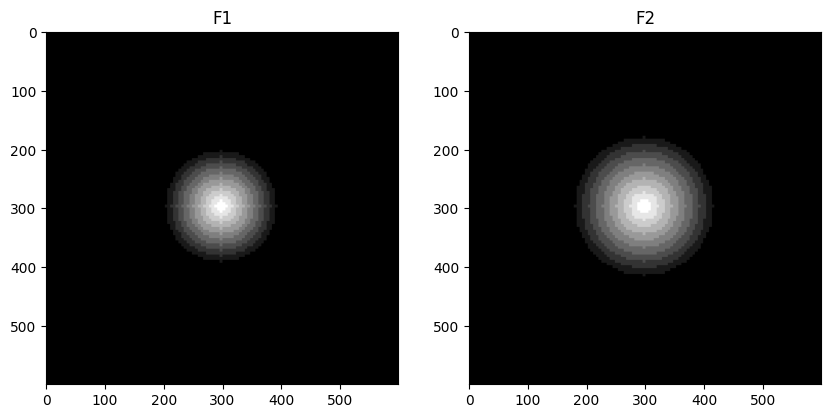

In [2]:
F1 = Image.open('./data/1.png', mode='r', formats=None)
F2 = Image.open('./data/2.png', mode='r', formats=None)
f1 = np.asarray(F1)
f2 = np.asarray(F2)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(F1, cmap = plt.cm.gray)
plt.title('F1')
plt.subplot(1, 2, 2)
plt.imshow(F2, cmap = plt.cm.gray)
plt.title('F2')

In [3]:
f1.shape

(600, 600, 3)

#### A) Au TP1, vous avez réalisé de l’estimation de mouvement de type forward par blocs entre F1 et F2. Procédez maintenant à de l’estimation backward par blocs entre F1 et F2

In [4]:
def DFD_blockWise2(img1, img2, x_ref, y_ref, r):
    a_x, a_y = 0, 0
    dfd_min = np.inf
    pas = 20
    
    ## Le parcours de -2r à 2r passera tous les blocs autours du blocs courant
    ## Avec un pas de r/2, on aura 16 blocs de comparaisons
    ## On choisira celui qui minisise l'EDFD pour déterminer (a_x, a_y)
    #-pas juqu'a pas // Si pas=6, -6 à 6
    for i in np.concatenate([np.arange(0, pas+1), np.arange(-pas, 0)]):
        for j in np.concatenate([np.arange(0, pas+1), np.arange(-pas, 0)]):
            x_target = x_ref + j
            y_target = y_ref + i
            

            if (y_target-r < 0 or y_target+r > img2.shape[0] or
                x_target-r < 0 or x_target+r > img2.shape[1]):
                continue
            
            current_block = img1[y_ref-r:y_ref+r, x_ref-r:x_ref+r]
            target_block = img2[y_target-r:y_target+r, x_target-r:x_target+r]
            
            dfd = np.sum((current_block - target_block)**2)

            if (dfd < dfd_min):
                dfd_min = dfd
                a_y, a_x = i, j
            
            if (dfd_min == 0):
                break
    return a_x, a_y 


In [5]:
def computeVector(r, p, function, img1, img2):
    """
    Renvoie la liste de chaque vecteurs correspondant à chaque pixel
    
    r: voisinage de chaque pixel
    p: pas de calcul entre chaque pixel
    function: fonction de calcule du vecteur
    
    return VX : la liste des coordonnées x de chaque vecteurs de mouvements
           VY : la liste des coordonnées y de chaque vecteurs de mouvements
    """
    VX, VY = [], []
    h1, w1 = img1.shape[0], img1.shape[1]
    
    for y in range(r, h1-r+1, p):
        for x in range(r, w1-r+1, p):
            v1, v2 = function(img1, img2, x, y, r)
            VX.append(v1)
            VY.append(v2)
    return VX, VY

In [6]:
def displayVector(VX, VY, r, pas, img, title=""):
    """
    Affichage des vecteurs sur l'image img
    """
    h1, w1 = img.height, img.width
    x = np.arange(r, w1-r+1, pas)
    y = np.arange(r, h1-r+1, pas)
    X, Y = np.meshgrid(x, y)

    fig, ax = plt.subplots(figsize =(10, 7))
    plt.imshow(img)
    ax.quiver(X, Y, np.array(VX, dtype=float), np.array(VY, dtype=float), 
              color='r', angles='xy', scale_units='xy', scale=1)
    plt.title(title)
    plt.show()

r=30, p=30, vx_shape=361, vy_shape=361


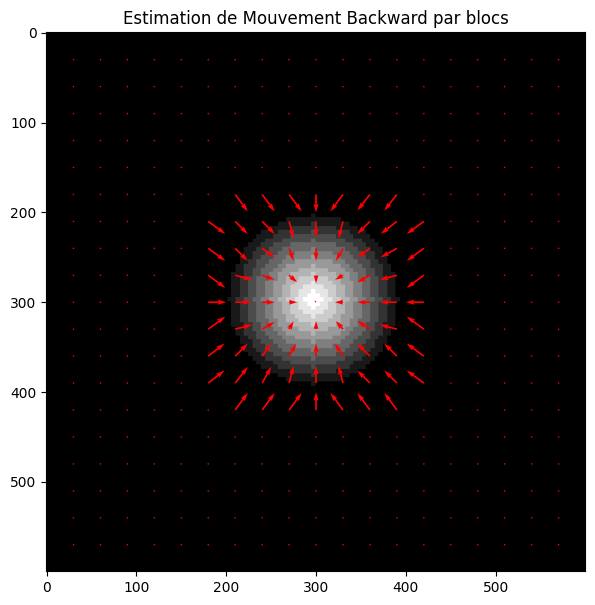

CPU times: total: 6.73 s
Wall time: 6.81 s


In [7]:
%%time
r = f1.shape[0]//20
p = f1.shape[0]//20

VX, VY = computeVector(r, p, DFD_blockWise2, f2, f1)
print(f"r={r}, p={p}, vx_shape={len(VX)}, vy_shape={len(VY)}")
displayVector(VX, VY, r, p, F1, "Estimation de Mouvement Backward par blocs")

#### B) Sachant que l’on va vouloir reconstruire la frame F2 à partir de F1, pourquoi a-t-on donc fait de la ME backward et pas de la ME forward ? Que se serait-il passé sinon ? (pensez à quels art´efacts visuels on aurait obtenu)

On fait de la Motion estimation backward car on veut reconstruire la frame F2 à partir de F1. Si on avait fait de la ME forward, on aurait eu des artéfacts visuels comme des trainées derrière les objets en mouvement ou bien des objets qui se dédoublent.

#### (C) Reconstruisez l’image F2 à partir de vos vecteurs de mouvements et de F1. Quelle est la MSE de reconstruction ?

In [8]:
def reconstruction_image(img1, VX, VY, r):
    h, w = img1.shape[0], img1.shape[1]
    block_size = r

    # Nombre de blocs dans l'image de référence
    nb_blocs_h = (h // block_size)-1
    nb_blocs_w = (w // block_size)-1
    
    # Initialisation de la nouvelle image
    new_img = np.zeros_like(img1)
    #print(new_img.shape)
    #print(VX.shape, VY.shape)
    #print(list(range((h // block_size)-1)))

    for j in range(nb_blocs_h):
        for i in range(nb_blocs_w):
            x_ref = r + i * block_size
            y_ref = r + j * block_size

            x_target = x_ref + VX[nb_blocs_h * j + i]
            y_target = y_ref + VY[nb_blocs_h * j + i]

            new_img[y_ref-r:y_ref+r, x_ref-r:x_ref+r]= img1[y_target-r:y_target+r, x_target-r:x_target+r]

    return new_img


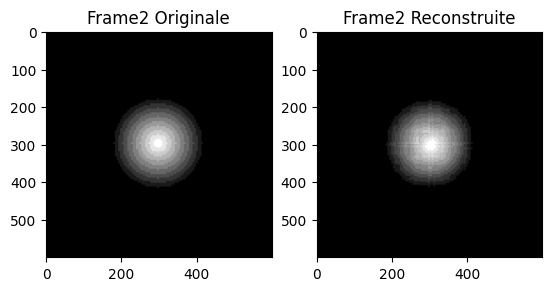

In [9]:
def display_reconstruct(img1, img2):
    r = img1.shape[0]//20
    p = img2.shape[0]//20
    VX, VY = computeVector(r, p, DFD_blockWise2, img2, img1)
    f3 = reconstruction_image(img1, np.array(VX), np.array(VY), p)

    plt.subplot(1, 2, 1)
    plt.imshow(f2)
    plt.title("Frame2 Originale")
    plt.subplot(1, 2, 2)
    plt.imshow(f3)
    plt.title("Frame2 Reconstruite")
    return f3

f3 = display_reconstruct(f1, f2)

In [10]:
def MSE(img1, img2):
    """
    Calcul de la MSE entre deux images
    """
    return np.mean((img1 - img2)**2)


print(f"Témoin MSE(f1, f2) {MSE(f1, f2)}")
print(f"MSE(f2, f3) : {MSE(f2, f3)}")

Témoin MSE(f1, f2) 10.041516666666666
MSE(f2, f3) : 4.938461111111111


#### (D) Supposant que l’on n’aura plus accès à F2, quelles sont les 3 données ”classiques” (en plus du paramètres de taille de bloc) dont on a besoin pour la reconstruire de façon parfaite en compensation de mouvement ?

Pour reconstruire de façon parfaite F2, on a besoin de la frame F1, des vecteurs de mouvement et de l'erreur entre la Frame F2 prédite I2' et la Frame F2 originale I2.

#### E) Reconstruisez F2 à partir de ces 3 données. Quelle est désormais la MSE de reconstruction ?

In [12]:
def reconstruction_image_V2(img1, img2, VX, VY, r):
    f3 = reconstruction_image(img1, VX, VY, r)
    eps = img2 - f3
    return  f3 + eps

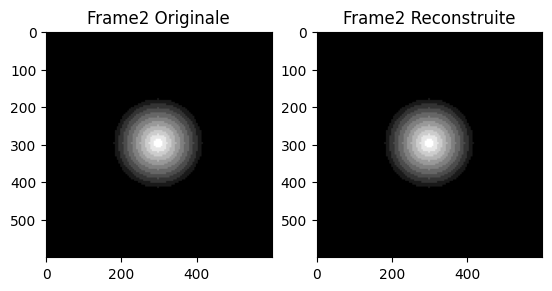

In [13]:
def display_reconstruct2(img1, img2):
    r = f1.shape[0]//20
    p = f1.shape[0]//20
    VX, VY = computeVector(r, p, DFD_blockWise2, f2, f1)
    f3 = reconstruction_image_V2(f1, f2, np.array(VX), np.array(VY), p)

    plt.subplot(1, 2, 1)
    plt.imshow(f2)
    plt.title("Frame2 Originale")
    plt.subplot(1, 2, 2)
    plt.imshow(f3)
    plt.title("Frame2 Reconstruite")

    return f3

f3 = display_reconstruct2(f1, f2)

In [14]:
print(f"Témoin MSE(f1, f2) : {MSE(f1, f2)}")
print(f"MSE(f2, f3) : {MSE(f2, f3)}")

Témoin MSE(f1, f2) : 10.041516666666666
MSE(f2, f3) : 0.0


On arrive à une MSE de reconstruction de 0.0 car on a les données nécessaires pour reconstruire F2 de façon parfaite.

#### (F) Expliquez quelles données on peut coder avec perte pour garder une qualité de reconstruction de F1 et F2 ”correcte”. Justifiez vos explications par des images de rendus

Nous prendrons une fonction de compression simple avec perte : la quantification (on divisera les valeurs de couleur de l'image en intervalles prédéfinis (niveaux de quantification))

On vérifiera la qualité de reconstruction en quantifiant progessivement sur les 3 données.

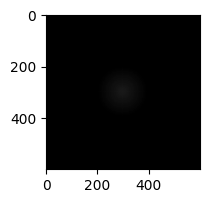

In [15]:
def compress_quantization(image, levels):
    image_array = np.array(image, dtype=np.float32)
    quantized_image = np.floor_divide(image_array, levels).astype(np.uint8)

    return quantized_image

def decompress_quantization(quantized_image, levels):
    decompressed_image = np.multiply(quantized_image, levels).astype(np.uint8)

    return decompressed_image

f1_quantized = compress_quantization(f1, 10)
plt.figure(figsize=(2, 2))
plt.imshow(f1_quantized)

In [16]:
f1_dequantized = decompress_quantization(f1_quantized, 10)
print(MSE(f1, f1_dequantized))

1.7740888888888888


##### Coder avec perte la frame F1

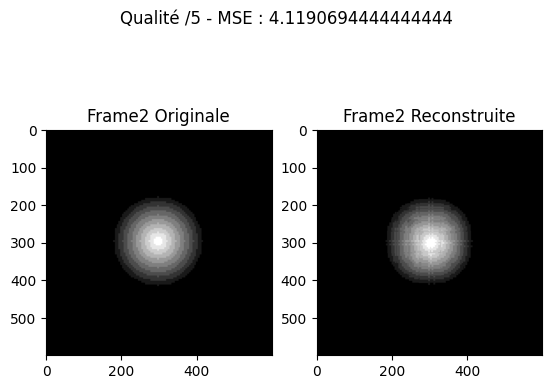

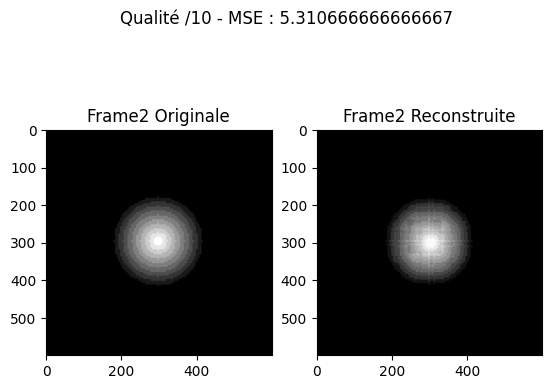

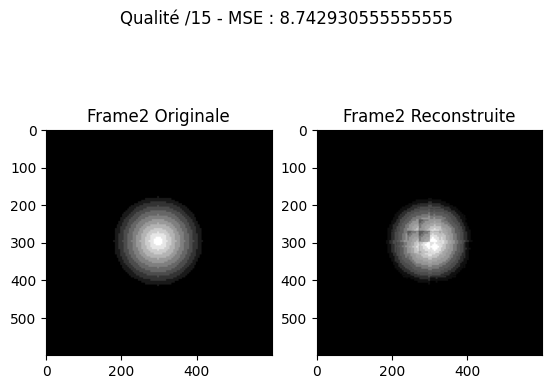

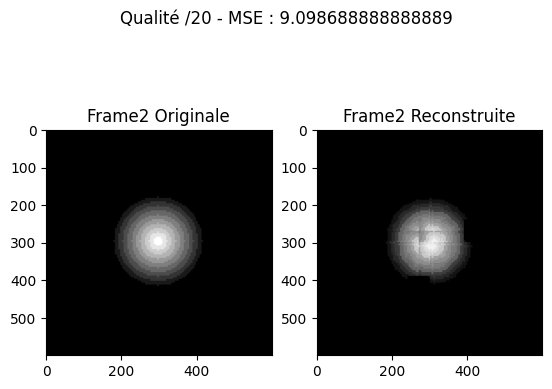

In [17]:
for quality in range(5, 21, 5):
    f1_quantized = compress_quantization(f1, quality)
    f1_dequantized = decompress_quantization(f1_quantized, quality)
    f3_code = display_reconstruct(f1_dequantized, f2)
    plt.suptitle(f"Qualité /{quality} - MSE : {MSE(f2, f3_code)}")
    plt.show()
    



##### Coder avec perte l'erreur F2 - F2 prédite

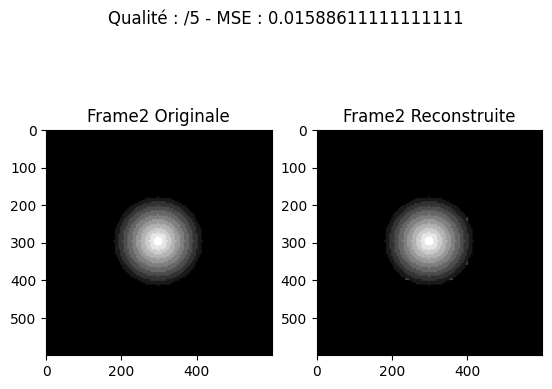

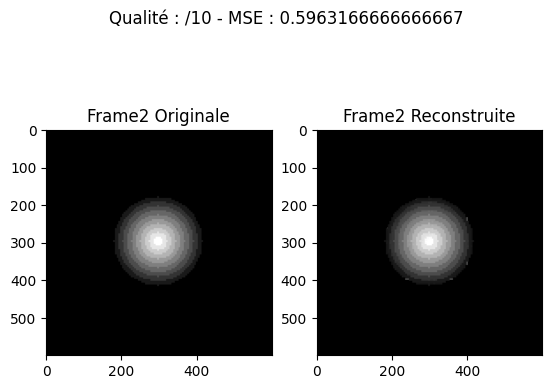

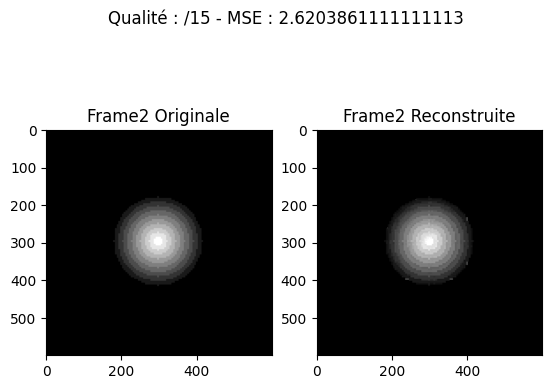

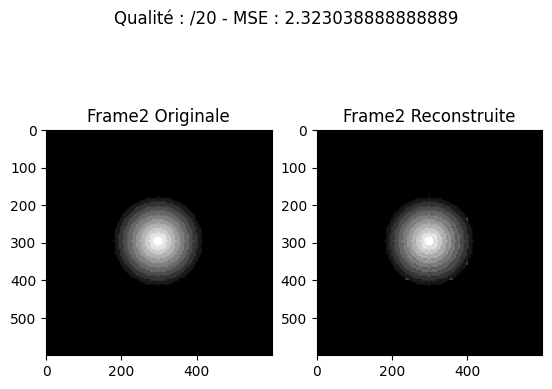

In [18]:
def reconstruction_image_V3(img1, img2, VX, VY, r, quality):
    f3 = reconstruction_image(img1, VX, VY, r)
    eps = img2 - f3
    eps_comp = compress_quantization(eps, quality)
    eps_decomp = decompress_quantization(eps_comp, quality)
    return  f3 + eps_decomp

def display_reconstruct3(img1, img2, quality):
    r = img1.shape[0]//20
    p = img1.shape[0]//20
    VX, VY = computeVector(r, p, DFD_blockWise2, f2, f1)
    f3 = reconstruction_image_V3(img1, img2, np.array(VX), np.array(VY), p, quality)

    plt.subplot(1, 2, 1)
    plt.imshow(img2)
    plt.title("Frame2 Originale")
    plt.subplot(1, 2, 2)
    plt.imshow(f3)
    plt.title("Frame2 Reconstruite")

    return f3

for quality in range(5, 21, 5):
    f3_code = display_reconstruct3(f1, f2, quality)
    plt.suptitle(f"Qualité : /{quality} - MSE : {MSE(f2, f3_code)}")
    plt.show()

##### Observations:

- On voit que l'on peut coder la frame F1 avec une quantification assez bonne mais avec des artéfacts qui se créent vite en augmentant le niveau de compression. 

- On voit que l'on peut coder l'erreur F2 - F2 prédite avec une quantification assez forte sans trop de perte de qualité de reconstruction.